In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 702, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 702 (delta 72), reused 63 (delta 34), pack-reused 591 (from 1)
Receiving objects: 100% (702/702), 1.10 MiB | 3.94 MiB/s, done.
Resolving deltas: 100% (454/454), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.read_datasets import read_sipgate_dataset
from bin.utils.clean_sipgate_dataset import clean_sipgate_dataset
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
def results_to_dataframe(results: list[dict]):
    # Initialize an empty DataFrame
    columns = ["intent"] + list(list(results[0].values())[0]["results"].keys())
    df = pd.DataFrame(columns=columns)
    df.set_index("intent", inplace=True)

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            df.loc[intent_name] = results

    df["intent"] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [36]:
def dfs_to_stripplots(dfs: list[pd.DataFrame]):
    # make a dashboard of plots
    # where each plot is the distribution of a metric
    # across all intents
    n_metrics = len([col for col in dfs[0].columns if not dfs[0][col].isnull().all()]) - 1
    n_cols = 2
    n_rows = -(-n_metrics // n_cols)  # Ceiling division

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.flatten()
    colors = sns.color_palette("husl", n_rows)
    for i, metric in enumerate(dfs[0].columns[1:]):
        if metric == "intent":
            continue

        ax = axs[i]
        ax.set_title(metric)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

        for i, df in enumerate(dfs):
          x, y = df[metric].index, df[metric].values
          sns.stripplot(
            data=df,
            x=metric,
            ax=ax,
            color=colors[i],
            alpha=0.5,
            linewidth=0,
          )

    plt.tight_layout()
    plt.show()

In [38]:
def transform_dfs_to_metric_dfs(dfs: list[pd.DataFrame]):
    metric_dfs = []
    metrics = [
        col for col in dfs[0].columns
        if not dfs[0][col].isnull().all()
        and col != "intent"
        ]
    for metric in metrics:
      columns = ["intent"] + [f"df_{i}" for i in range(len(dfs))]
      df = pd.DataFrame(columns=columns)
      df.set_index("intent", inplace=True)
      for i, df_ in enumerate(dfs):
        df[f"df_{i}"] = df_[metric]
      df["intent"] = df.index
      df.reset_index(drop=True, inplace=True)
      metric_dfs.append(df)
    return metric_dfs

In [10]:
def load_df(dataset_name: str):
    gen_df = pd.read_csv(f"data/{dataset_name}.csv", encoding="utf-8")
    gen_df.rename(columns={"query": "text"}, inplace=True)
    gen_df = gen_df[gen_df["text"].apply(lambda x: isinstance(x, str))]
    return gen_df

In [12]:
dataset_names = [
    "persona_based_prompt_s1_data",
    "few_shot_simple_data",
    "chain_of_thought_simple_data",
    "few_shot_simple_data",
    "one_shot_simple_data",
]
raw_dfs = [load_df(dataset_name) for dataset_name in dataset_names]
ref_df = clean_sipgate_dataset(read_sipgate_dataset())

In [ ]:
framework = Framework()
evaluated_sets = []
for gen_df in raw_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets.append(df)

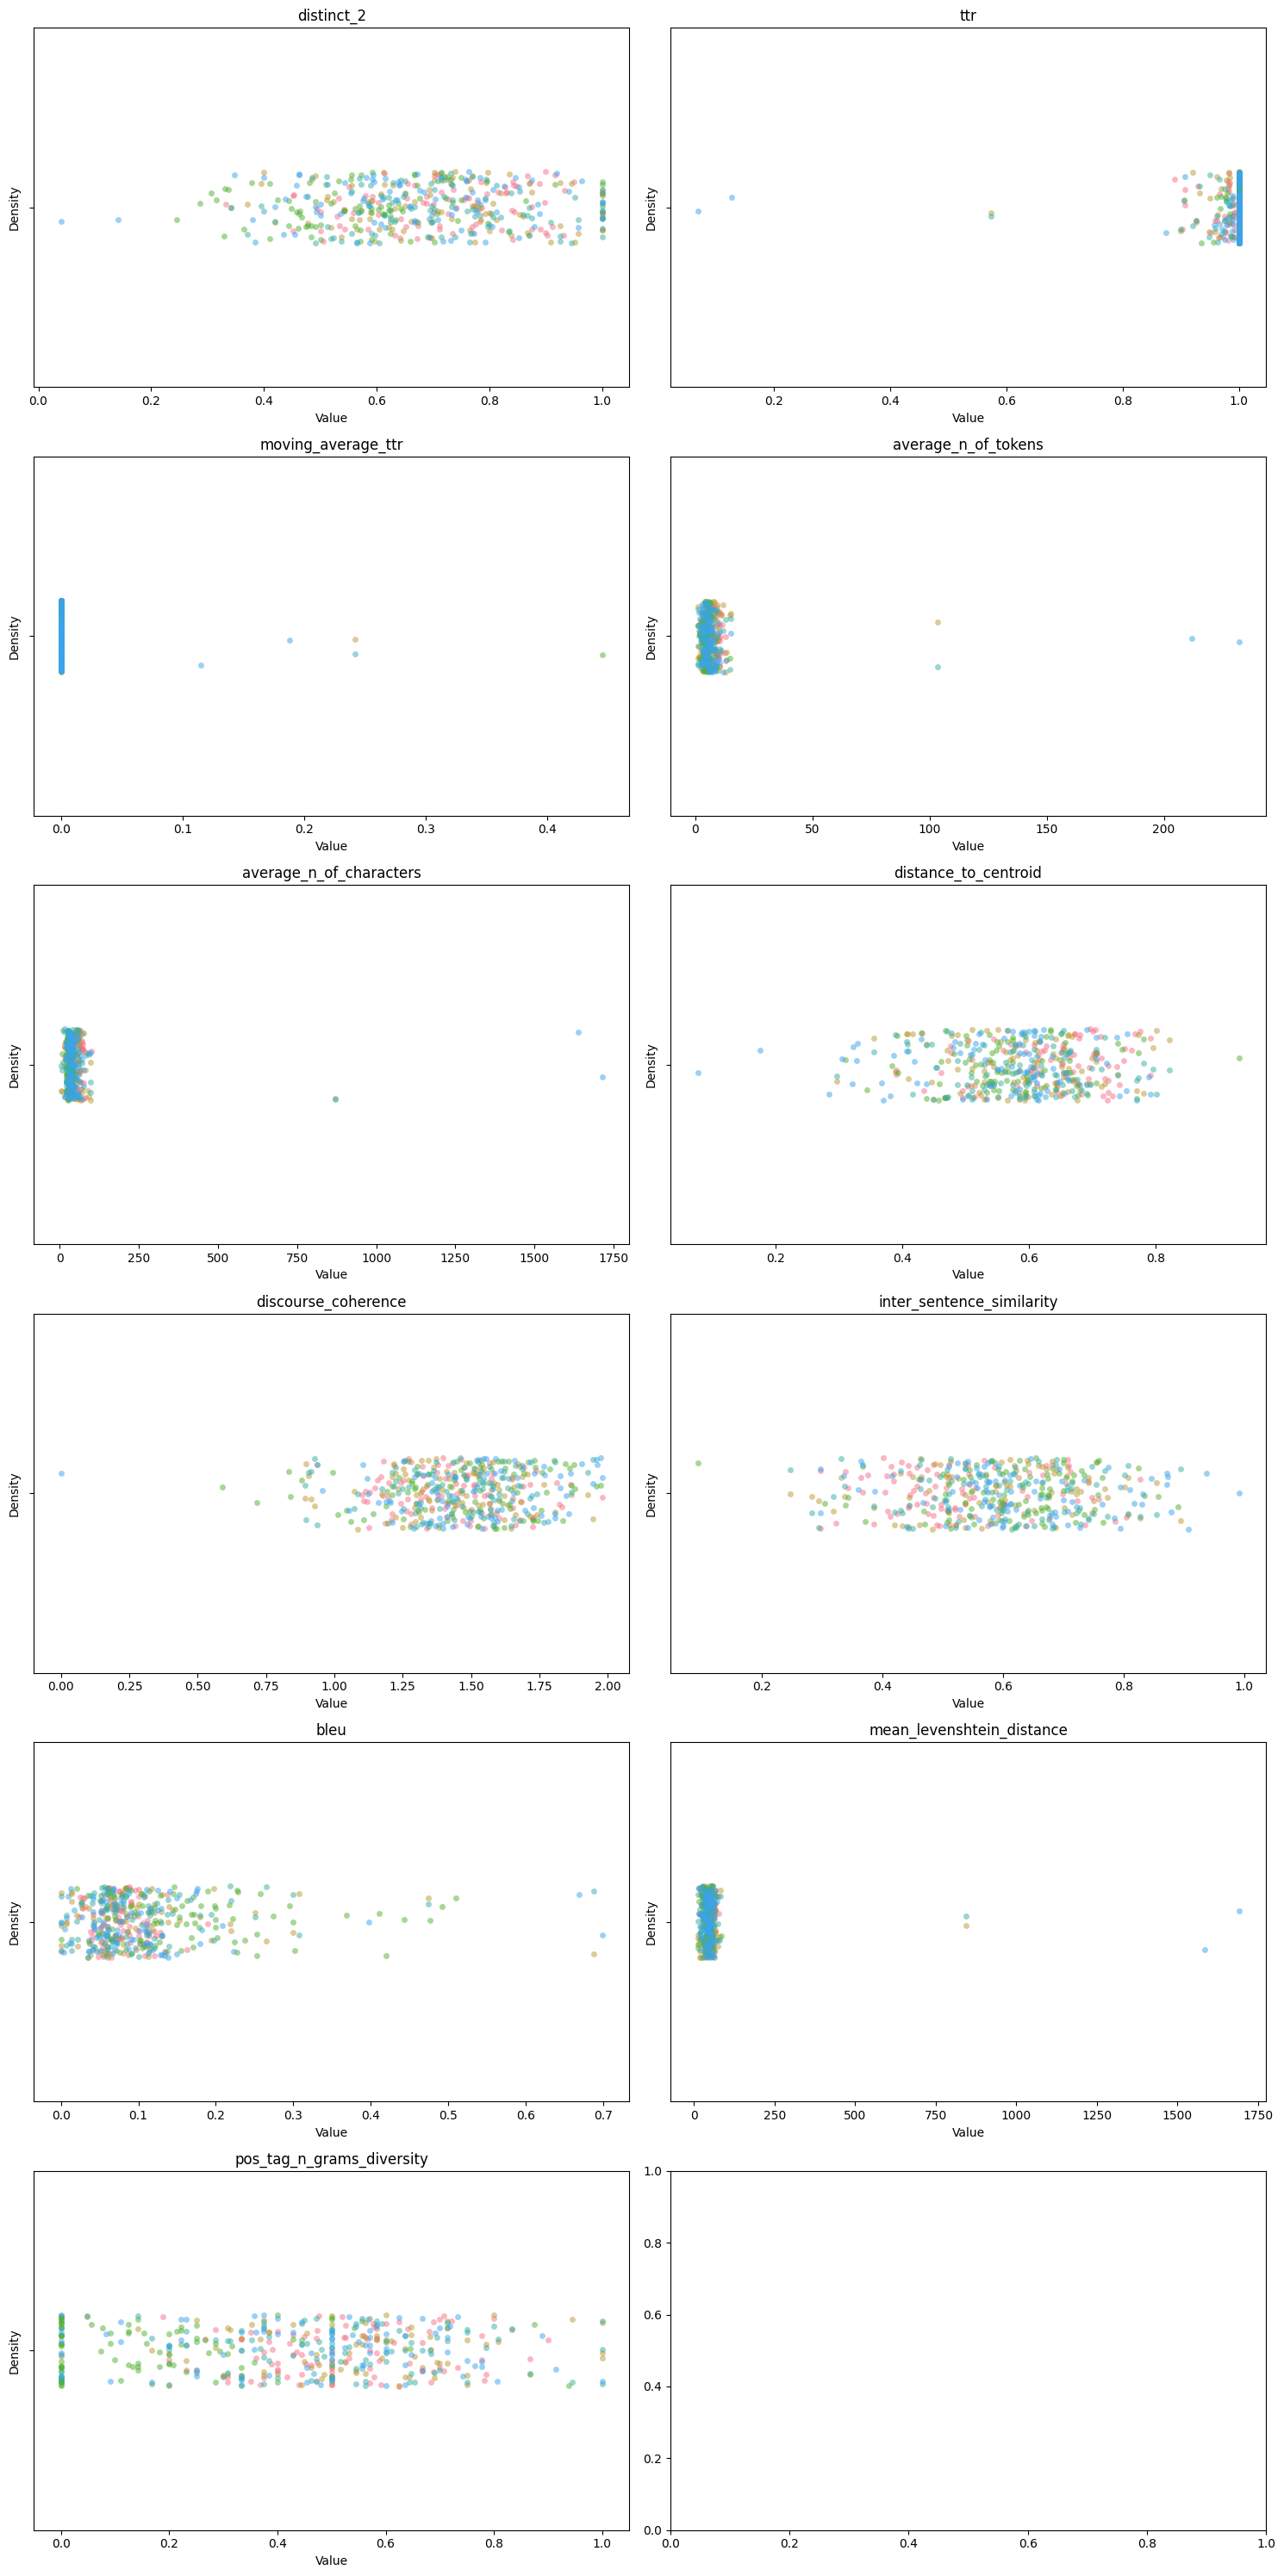

In [37]:
dfs_to_stripplots(evaluated_sets)

In [ ]:
metric_dfs = transform_dfs_to_metric_dfs(evaluated_sets)
metric_dfs

In [53]:
def catplot_metric_dfs(metric_dfs: list[pd.DataFrame]):
    n_metrics = len(metric_dfs)
    n_cols = 2
    n_rows = -(-n_metrics // n_cols)  # Ceiling division
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten axs in case of single row
    axs = axs.flatten() if n_metrics > 1 else [axs]

    for i, metric_df in enumerate(metric_dfs):
        metric_df_melted = metric_df.melt(id_vars=['intent'], var_name='Metric', value_name='Value')
        sns.boxplot(data=metric_df_melted, x='Metric', y='Value', ax=axs[i])
        axs[i].set_title(f'Metric {i+1}')

    plt.tight_layout()
    plt.show()

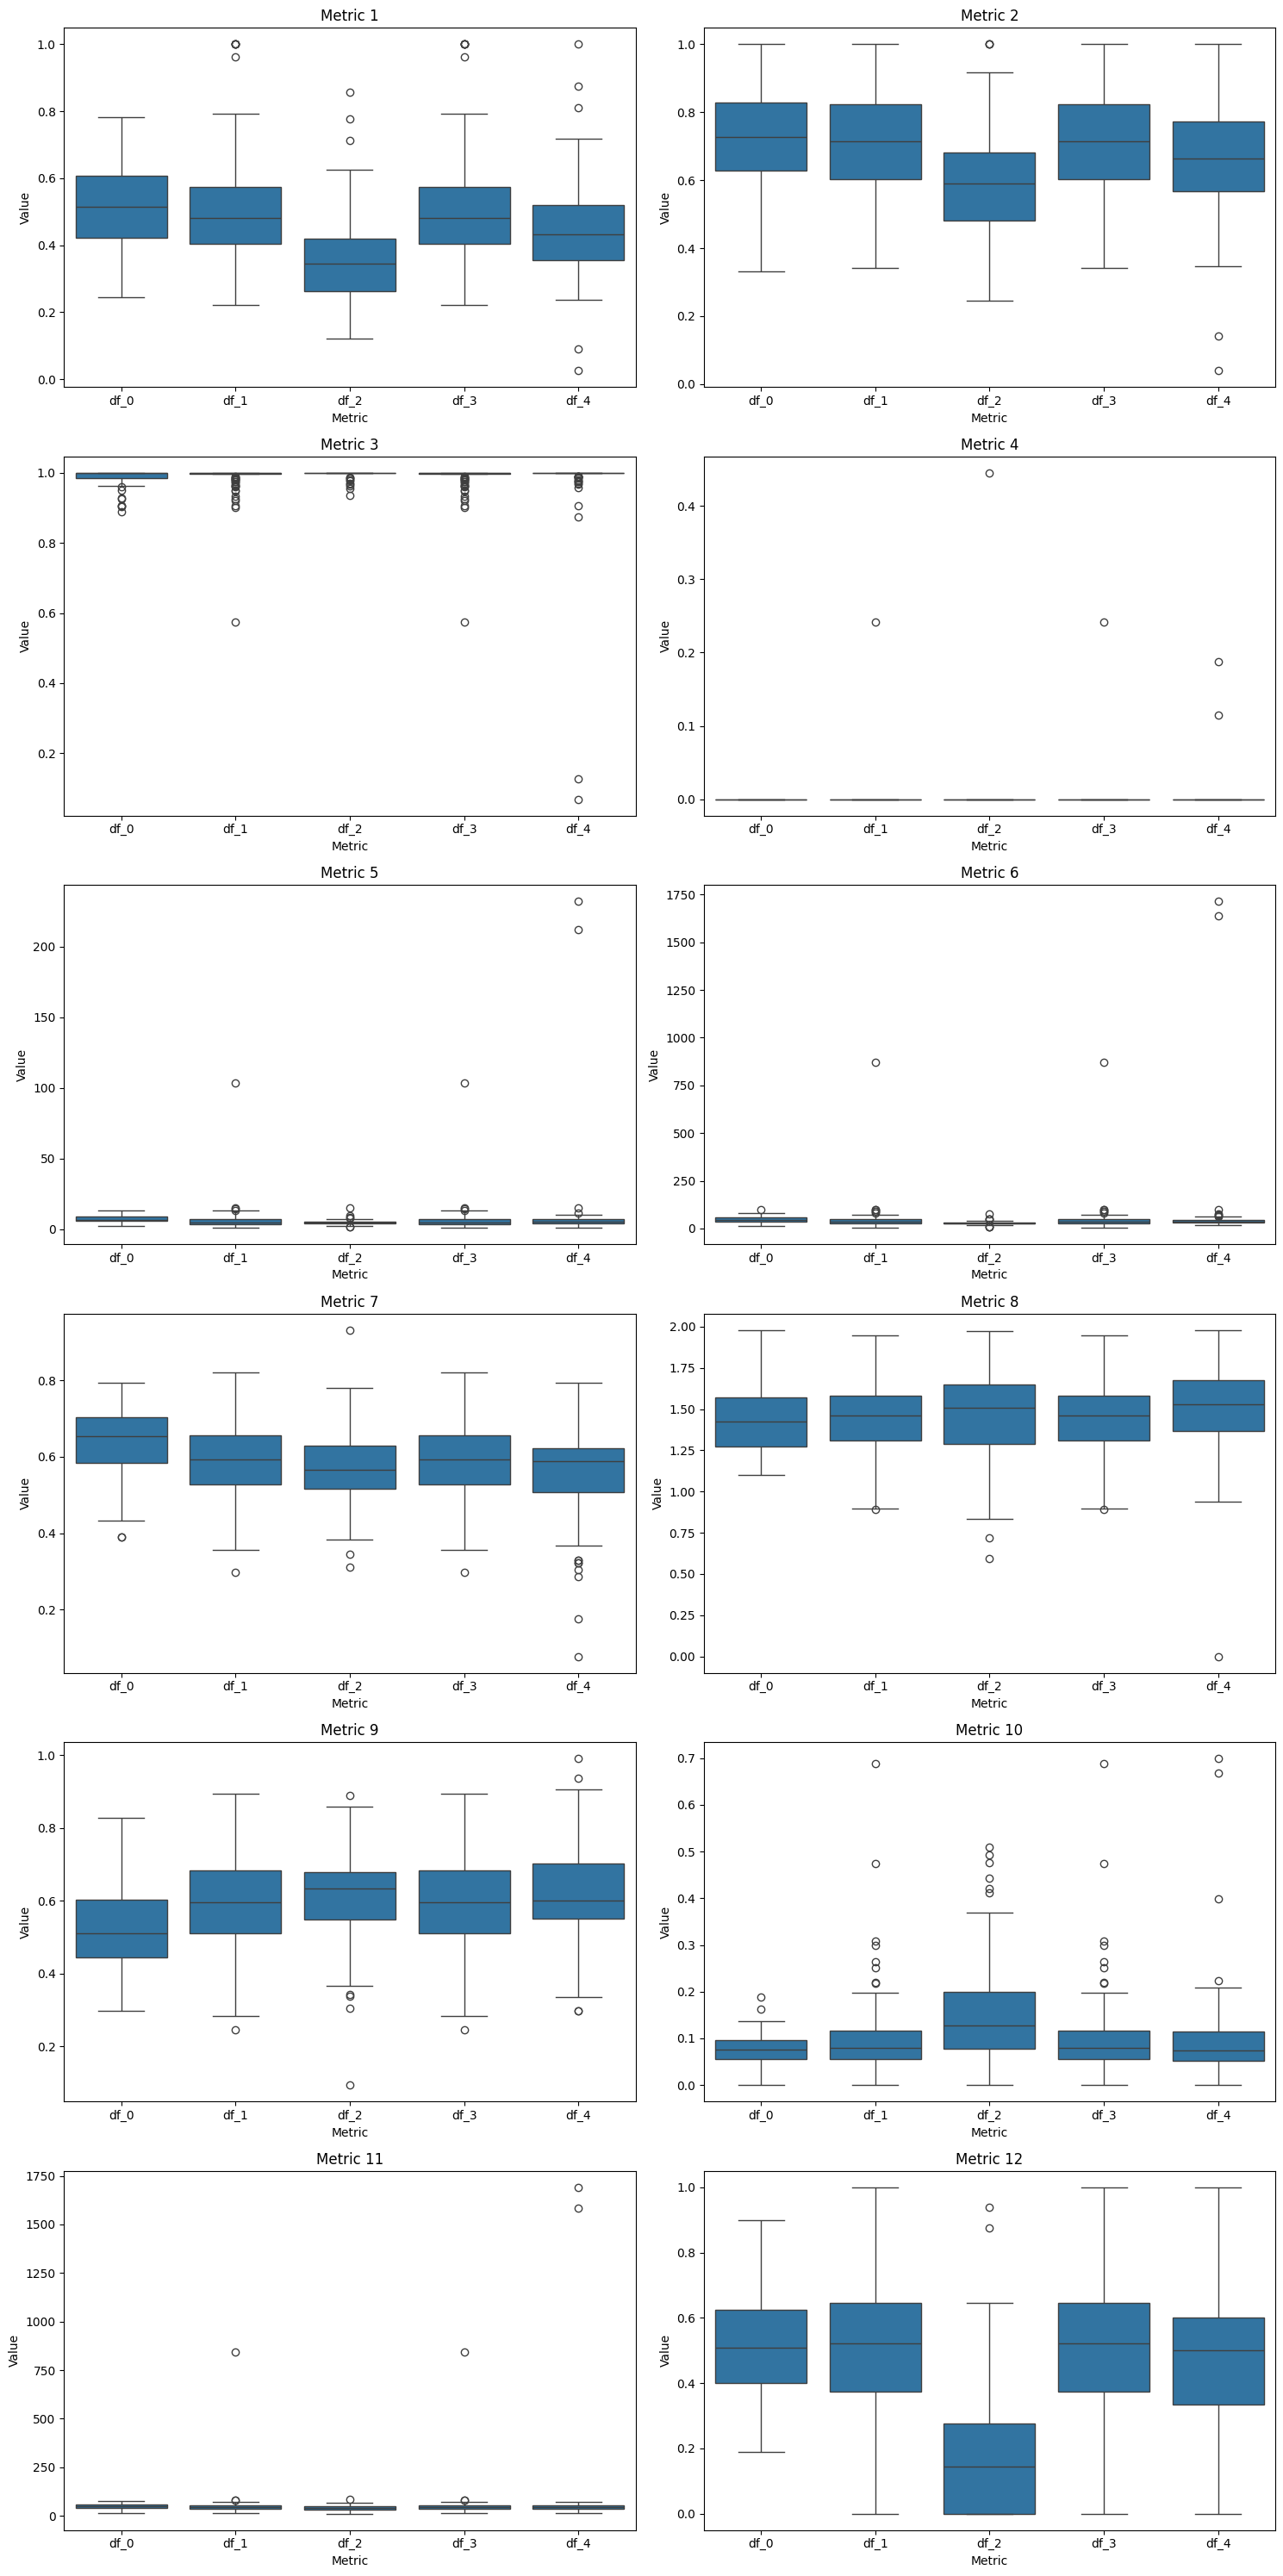

In [54]:
catplot_metric_dfs(metric_dfs)